#### FIND HF

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import time
import GeDiM4Py as gedim
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn
import os
import random
import time
import csv

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [4]:
def set_seed(seed=23):
    random.seed(seed)                        # seed Python random
    np.random.seed(seed)                     # seed numpy random
    torch.manual_seed(seed)                  # seed CPU
    torch.cuda.manual_seed(seed)             # seed GPU (if available)
    torch.cuda.manual_seed_all(seed)         # se hai più GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [5]:
set_seed(23)

In [6]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
    #print("vecu max:", np.max(vecu))
    #print("mu_1 * vecu max:", np.max(mu_1 * vecu))
    return values_nl_b.ctypes.data

# f_4 (parte con la g)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


In [7]:
meshSize = 0.001
order = 1

In [8]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

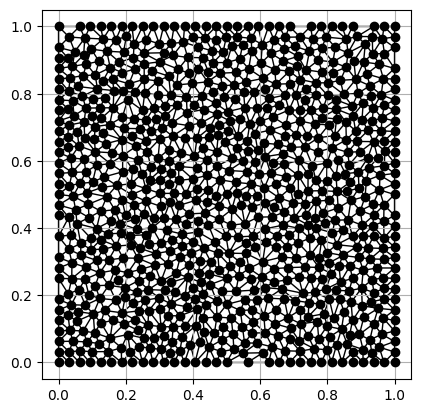

In [9]:
gedim.PlotMesh(mesh)

In [10]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

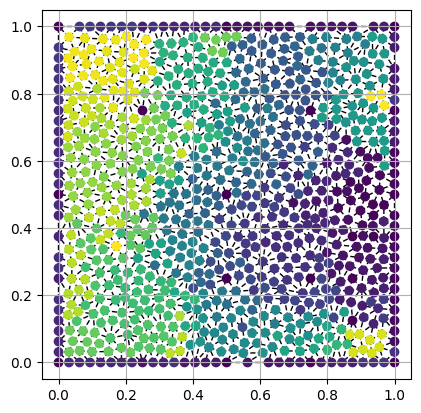

In [11]:
gedim.PlotDofs(mesh, dofs, strongs)

In [12]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [13]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [14]:
test_set = np.random.uniform(low=0.1, high=1, size=(100, 2)) # test set

In [15]:
# Troviamo le soluzioni high fidelity 

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

# append the solutions
sol_hf = []
# append the sum of total time taken to solve ONLY the linear systems in the while loop, for each mu is it a sum of the total time taken in all ietrations
times_hf = []
# append solution on quadrature points
sol_quad_hf = []
#append solution derivative wrt x on quadraure points
der_x_quad_hf = []
#append solution derivative wrt y on quadraure points
der_y_quad_hf = []


for mu in test_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0

    # INIZIALIZE TO 0 FOR EACH MU   
    time_hf = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction

        time_start = time.time()
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        time_hf += time.time() - time_start
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    sol_hf.append(np.copy(u_k))
    times_hf.append(time_hf)
    # save solutions on quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)
    #append solution derivative wrt x on quadraure points
    der_x_quad_hf.append(solution_x_hf)
    #append solution derivative wrt y on quadraure points
    der_y_quad_hf.append(solution_y_hf)
last_sol = u_k

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    9.453471e-03   2      100      mu = (0.566, 0.952)
713      0.064    1.422986e-06   3      100      mu = (0.566, 0.952)
713      0.064    3.728250e-14   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    4.503949e-03   2      100      mu = (0.789, 0.354)
713      0.064    1.086983e-07   3      100      mu = (0.789, 0.354)
713      0.064    1.015308e-16   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    3.710673e-03   2      100      mu = (0.299, 0.718)
713      0.064    7.370379e-08   3      100      mu = (0.299, 0.718)
713      0.064    7.913749e-17   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.911868e-03   2

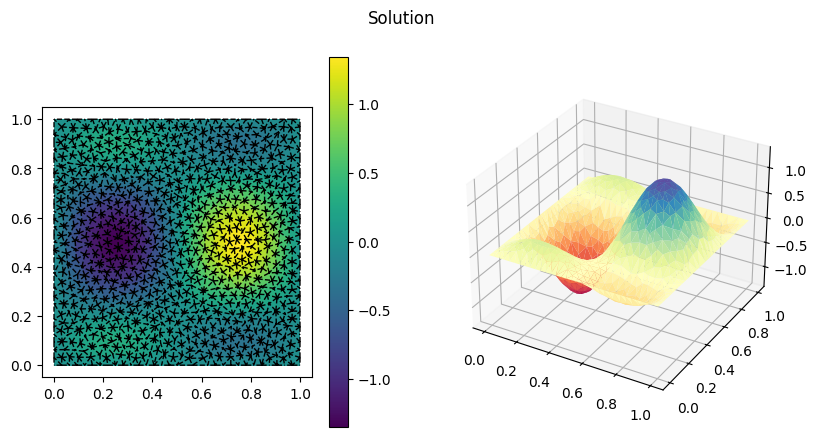

[0.00020986 0.00020986 0.00020986 ... 0.00026137 0.00026137 0.00026137]


In [16]:
# Plot on the last mu of test_set
gedim.PlotSolution(mesh, dofs, strongs, last_sol, np.zeros(problemData['NumberStrongs']))
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(last_sol, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, solution_hf, lib)
print(quadratureWeights)

#### PINN

#### Defintion of the nets to be used
input dimension is 4 : (x0, x1, mu0, m1)

In [17]:

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 64)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        output = self.out(x)
        return output

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 64)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)   # layer aggiunto
        self.out = nn.Linear(64, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output

class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 128)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)   # layer aggiunto
        self.out = nn.Linear(128, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output


class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 3 hidden layers e attivazione Tanh
        self.fc1 = nn.Linear(4, 128)    # input: x0, x1, mu0, mu1
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)   # layer aggiunto
        self.out = nn.Linear(64, 1)    # output: u(x, mu)
        self.activation = nn.Tanh()

    def forward(self, xmu):
        x = self.activation(self.fc1(xmu))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))  # nuovo layer
        output = self.out(x)
        return output
# fa schifo (credo problema sia la sigmoide)

class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(4,5)
        self.hidden_layer1 = nn.Linear(5,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x):
        input = x
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        return output



# ------------------------------------------------------------------
# Net6 – quattro hidden layer da 128→128→128→64
# ------------------------------------------------------------------
class Net6(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)   # layer extra
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)     # layer già presente in Net4
        self.out = nn.Linear(64, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = self.act(self.fc1(xmu))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))   # nuovo passaggio
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        return self.out(x)


# ------------------------------------------------------------------
# Net7 – cinque hidden layer a piramide 256→192→128→96→64
# ------------------------------------------------------------------
class Net7(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 192)
        self.fc3 = nn.Linear(192, 128)
        self.fc4 = nn.Linear(128, 96)    # layer extra
        self.fc5 = nn.Linear(96, 64)
        self.out = nn.Linear(64, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = self.act(self.fc1(xmu))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))   # nuovo layer
        x = self.act(self.fc5(x))
        return self.out(x)


# ------------------------------------------------------------------
# Net8 – sei hidden layer uniformi 128↦128, con residual skip
# ------------------------------------------------------------------
class Net8(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(4 if i == 0 else 128, 128)
                                     for i in range(6)])  # 6 hidden layer
        self.out = nn.Linear(128, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = xmu
        for i, layer in enumerate(self.layers):
            h = self.act(layer(x))
            # skip residual ogni due layer
            if i % 2 == 1:
                x = (x + h) / 2
            else:
                x = h
        return self.out(x)

# ------------------------------------------------------------------
# Net9 – sei hidden layer 256→256→192→128→96→64 (Tanh)
# ------------------------------------------------------------------
class Net9(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 192)
        self.fc4 = nn.Linear(192, 128)
        self.fc5 = nn.Linear(128, 96)
        self.fc6 = nn.Linear(96, 64)
        self.out = nn.Linear(64, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = self.act(self.fc1(xmu))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        x = self.act(self.fc6(x))
        return self.out(x)


# ------------------------------------------------------------------
# Net10 – cinque hidden layer piramidale 256→192→128→96→64 (ReLU)
# ------------------------------------------------------------------
class Net10(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 192)
        self.fc3 = nn.Linear(192, 128)
        self.fc4 = nn.Linear(128, 96)
        self.fc5 = nn.Linear(96, 64)
        self.out = nn.Linear(64, 1)
        self.act = nn.ReLU()

    def forward(self, xmu):
        x = self.act(self.fc1(xmu))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        return self.out(x)
# ------------------------------------------------------------------
# Net11 – 8 hidden layer con skip‑connection ogni 2 layer (Tanh)
# schema: 4 → 256 → 256  ↘
#                     256 → 192 → 192  ↘
#                                   192 → 128 → 128  ↘
#                                                 128 → 64 → 64 → out
# ------------------------------------------------------------------

class Net11(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_in = nn.Linear(4, 256)

        # blocco 1
        self.b1_1 = nn.Linear(256, 256)
        self.b1_2 = nn.Linear(256, 256)   # skip: in + out

        # blocco 2
        self.b2_1 = nn.Linear(256, 192)
        self.b2_2 = nn.Linear(192, 192)   # skip

        # blocco 3
        self.b3_1 = nn.Linear(192, 128)
        self.b3_2 = nn.Linear(128, 128)   # skip

        # testa finale
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)

        self.act = nn.Tanh()

    def forward(self, xmu):
        x = self.act(self.fc_in(xmu))       # 4 → 256

        # ---- blocco 1 ------------------------------------------------
        h = self.act(self.b1_1(x))
        h = self.act(self.b1_2(h))
        x = x + h                           # skip (256)

        # ---- blocco 2 ------------------------------------------------
        h = self.act(self.b2_1(x))          # 256 → 192
        h = self.act(self.b2_2(h))
        x = h + nn.functional.pad(x, (0, -64))  # align dims 256→192

        # ---- blocco 3 ------------------------------------------------
        h = self.act(self.b3_1(x))          # 192 → 128
        h = self.act(self.b3_2(h))
        x = h + x[:, :128]                  # skip (taglia a 128)

        # ---- testa finale -------------------------------------------
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        return self.out(x)

# ------------------------------------------------------------------
# Net12 – sei hidden layer uniformi 128↦128, con residual skip
# ------------------------------------------------------------------
class Net12(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(4 if i == 0 else 128, 128)
                                     for i in range(10)])  # 10 hidden layer
        self.out = nn.Linear(128, 1)
        self.act = nn.Tanh()

    def forward(self, xmu):
        x = xmu
        for i, layer in enumerate(self.layers):
            h = self.act(layer(x))
            # skip residual ogni due layer
            if i % 2 == 1:
                x = (x + h) / 2
            else:
                x = h
        return self.out(x)




In [ ]:
# ------------------------ Calcolo del residuo PDE ------------------------
def pde_residual(xmu, net):
    """
    Calcola il residuo della PDE in ogni punto (interno al dominio)
    -xmu: tensor Nx4 con (x0, x1, mu0, mu1)
    -net: la rete neurale che approssima u
    """
    xmu.requires_grad_(True)      # necessario per calcolare derivate rispetto a xmu
    u = net(xmu)                 # output della rete: u(x,mu)

    # Calcolo gradiente di u rispetto a input (x0, x1) per le derivate prime
    grads = torch.autograd.grad(u.sum(), xmu, create_graph=True)[0]

    u_x0 = grads[:, 0:1]          # ∂u/∂x0
    u_x1 = grads[:, 1:2]          # ∂u/∂x1

    # Calcolo derivate seconde per laplaciano
    u_x0x0 = torch.autograd.grad(u_x0.sum(), xmu, create_graph=True)[0][:, 0:1]  # ∂²u/∂x0²
    u_x1x1 = torch.autograd.grad(u_x1.sum(), xmu, create_graph=True)[0][:, 1:2]  # ∂²u/∂x1²
    laplacian_u = u_x0x0 + u_x1x1  # ∆u

    # Estrazione parametri mu0 e mu1
    mu0 = xmu[:, 2:3]
    mu1 = xmu[:, 3:4]

    # Coordinate spaziali
    x0 = xmu[:, 0:1]
    x1 = xmu[:, 1:2]

    # Termine sorgente g(x;mu)
    g = 100 * torch.sin(2 * np.pi * x0) * torch.cos(2 * np.pi * x1)

    # Termine non lineare con mu0, mu1
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Residuo PDE: -∆u + nonlinear - g = 0
    residual = -laplacian_u + nonlinear - g
    return residual

In [19]:
# ------------------------ Generazione punti dominio e bordo ------------------------
def generate_domain_points(N_interior, N_boundary, mu0_range, mu1_range):
    """
    Genera punti interni e di bordo del dominio con campionamento uniforme
    anche dei parametri mu0, mu1 negli intervalli specificati
    """
    mu0_min, mu0_max = mu0_range
    mu1_min, mu1_max = mu1_range

    # --- Punti interni ---
    x0 = torch.rand(N_interior, 1)  # coordinate x0 in (0,1)
    x1 = torch.rand(N_interior, 1)  # coordinate x1 in (0,1)
    mu0 = mu0_min + (mu0_max - mu0_min) * torch.rand(N_interior, 1)  # parametri mu0 casuali nell’intervallo
    mu1 = mu1_min + (mu1_max - mu1_min) * torch.rand(N_interior, 1)  # parametri mu1 casuali nell’intervallo
    xmu_interior = torch.cat([x0, x1, mu0, mu1], dim=1)

    # --- Punti sul bordo ---
    xb = []
    for side in range(4):
        s = torch.rand(N_boundary, 1)          # coordinata variabile sul lato
        zeros = torch.zeros_like(s)             # vettore di zeri
        ones = torch.ones_like(s)               # vettore di uni

        if side == 0:
            # lato inferiore y=0
            x0b, x1b = s, zeros
        elif side == 1:
            # lato superiore y=1
            x0b, x1b = s, ones
        elif side == 2:
            # lato sinistro x=0
            x0b, x1b = zeros, s
        else:
            # lato destro x=1
            x0b, x1b = ones, s

        mu0b = mu0_min + (mu0_max - mu0_min) * torch.rand(N_boundary, 1)  # mu0 bordo
        mu1b = mu1_min + (mu1_max - mu1_min) * torch.rand(N_boundary, 1)  # mu1 bordo

        xb.append(torch.cat([x0b, x1b, mu0b, mu1b], dim=1))

    xmu_boundary = torch.cat(xb, dim=0)
    n_boundary_points = len(xmu_boundary)



    return xmu_interior, xmu_boundary

In [20]:
def train_pinn_poly(
        net, net_name,
        epochs=20000, N_interior=1500, N_boundary=200,
        lr=1e-3, mu0_range=(0.1, 1.0), mu1_range=(0.1, 1.0),
        power=2.0, seed=23,
        lambda_weight=1.0,               # <-- aggiunto parametro lambda di default 1.0
        csv_path=None,
        log_step=200
):
    # Se non specificato, crea il nome del file CSV includendo lambda_weight
    if csv_path is None:
        #scrivo jupyter cosi non sovrascive a quello che già ho
        csv_path = f"jupyter_training_log_lambda{lambda_weight:.3f}.csv"

    # reproducibility --------------------------------------------------
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: (1 - epoch / epochs) ** power)

    # prepara CSV ------------------------------------------------------
    first_write = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        if first_write:
            writer.writerow(["net", "epoch",
                             "loss", "pde_loss", "bc_loss",
                             "epoch_time_s", "elapsed_s", "lambda_weight"])

    # training ---------------------------------------------------------
    t0 = time.time()
    prev_time = t0

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        net.train()

        # sample points
        xmu_int, xmu_bnd = generate_domain_points(
            N_interior, N_boundary, mu0_range, mu1_range
        )
        xmu_int, xmu_bnd = xmu_int.to(device), xmu_bnd.to(device)

        # losses
        res_int  = pde_residual(xmu_int, net)
        loss_pde = torch.mean(res_int ** 2)
        u_bnd    = net(xmu_bnd)
        loss_bc  = torch.mean(u_bnd ** 2)
        loss     = loss_pde + lambda_weight * loss_bc    # usa lambda_weight qui

        # optimise
        loss.backward()
        optimizer.step()
        scheduler.step()

        # timing
        now = time.time()
        epoch_time = now - prev_time
        elapsed    = now - t0
        prev_time  = now

        # log
        if epoch % log_step == 0 or epoch == 1 or epoch == epochs:
            log = (f"[{net_name}] Ep {epoch}: "
                   f"loss={loss.item():.6f}, pde={loss_pde.item():.6f}, "
                   f"bc={loss_bc.item():.6f}, λ={lambda_weight:.3f}, "
                   f"dt={epoch_time:.3f}s, "
                   f"elapsed={elapsed/60:.1f}m")
            print(log)

            with open(csv_path, "a", newline="") as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([net_name, epoch,
                                 f"{loss.item():.6f}",
                                 f"{loss_pde.item():.6f}",
                                 f"{loss_bc.item():.6f}",
                                 f"{epoch_time:.3f}",
                                 f"{elapsed:.3f}",
                                 f"{lambda_weight:.3f}"])

    total_min = (time.time() - t0) / 60
    print(f"{net_name} training complete in {total_min:.1f} min "
          f"(final loss {loss.item():.6f})")


In [22]:
"""net = Net11()
train_pinn(net,
           epochs=20000,
           N_interior=1500,
           N_boundary=200,
           lr=1e-3,
           mu0_range=(0.1, 1.0),
           mu1_range=(0.1, 1.0), lambda_weight = 1.0)"""

'net = Net11()\ntrain_pinn(net,\n           epochs=20000,\n           N_interior=1500,\n           N_boundary=200,\n           lr=1e-3,\n           mu0_range=(0.1, 1.0),\n           mu1_range=(0.1, 1.0), lambda_weight = 1.0)'

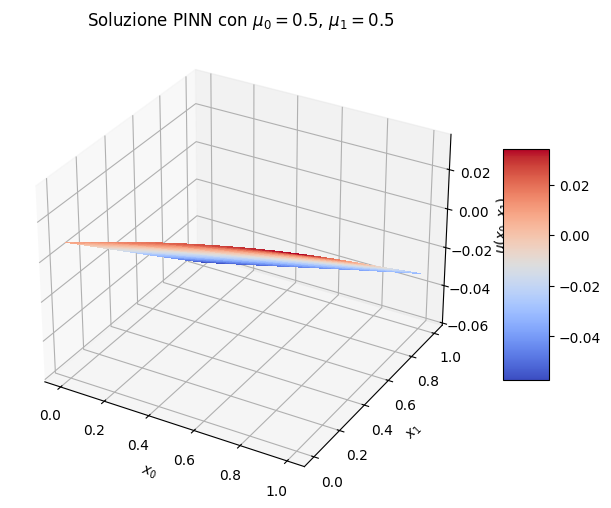

In [23]:
"""# Fissa parametri mu0 e mu1
mu0_val = 0.5
mu1_val = 0.5

# Griglia su (x0, x1)
x0 = np.arange(0, 1.01, 0.02)
x1 = np.arange(0, 1.01, 0.02)
X0, X1 = np.meshgrid(x0, x1)

# Prepara input per la rete: (x0, x1, mu0, mu1)
x0_flat = X0.flatten()[:, None]
x1_flat = X1.flatten()[:, None]
mu0_flat = mu0_val * np.ones_like(x0_flat)
mu1_flat = mu1_val * np.ones_like(x0_flat)

inputs = np.hstack([x0_flat, x1_flat, mu0_flat, mu1_flat])
inputs_torch = torch.from_numpy(inputs).float()

# Predizione rete (assumendo 'net' già addestrata e in eval mode)
net.eval()
with torch.no_grad():
    u_pred = net(inputs_torch).cpu().numpy()

# Ricostruisci la matrice della soluzione
U = u_pred.reshape(X0.shape)

# Plot 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X0, X1, U, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$u(x_0,x_1)$')
ax.set_title(f'Soluzione PINN con $\\mu_0={mu0_val}$, $\\mu_1={mu1_val}$')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()"""

#### View all values of finals losses and mean losses

In [18]:
# – installazione (solo la prima volta)
!pip install pandas matplotlib
!python3 -m pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 8.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [19]:
import pandas as pd

df = pd.read_csv("training_log_lambda1.000.csv")

num_cols = ["loss", "pde_loss", "bc_loss"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# ---------- ultimi valori ----------
last_vals = (
    df.sort_values("epoch")
      .groupby("net")
      .tail(1)
      .set_index("net")[num_cols]
      .rename(columns=lambda c: f"last_{c}")
)

# ---------- medie solo da epoch 12000 in poi ----------
df_after_15k = df[df["epoch"] >= 15000]

mean_vals = (
    df_after_15k.groupby("net")[num_cols]
               .mean()
               .rename(columns=lambda c: f"mean_{c}")
)

# ---------- tabella finale ----------
summary = last_vals.join(mean_vals)[[
    "last_loss", "last_pde_loss", "last_bc_loss",
    "mean_loss", "mean_pde_loss", "mean_bc_loss"
]]

summary = summary.sort_values("last_loss")

print(summary.to_string())

#RESULTS FROM RUNS ON COLAB


         last_loss  last_pde_loss  last_bc_loss  mean_loss  mean_pde_loss  mean_bc_loss
net                                                                                    
Net11()   0.001857       0.000419      0.001437   0.047186       0.043906       0.00328


### BEST NET: NET11

Now that I found my best net, I need to tune $\lambda$. i would like to have the loss on the border and that isnide the domanin to be circa of the same scale. Let's plot them and their ratio.

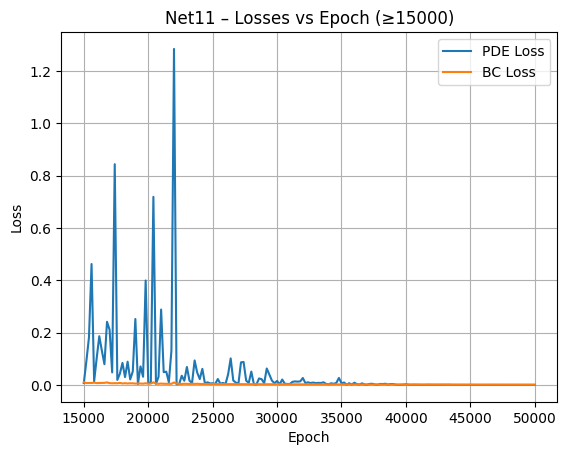

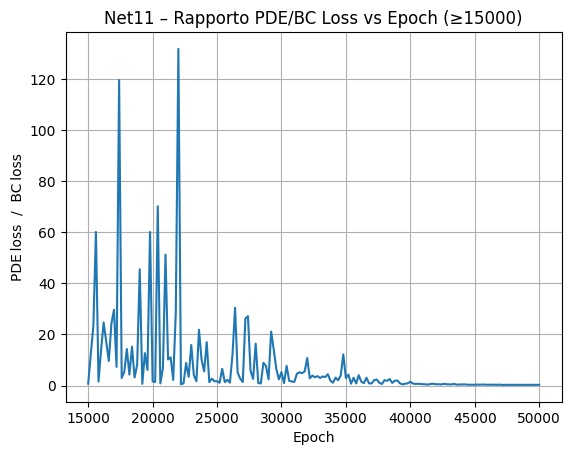

In [20]:
df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 15000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / df_plot["bc_loss"]

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  BC loss")
plt.grid(True)
plt.show()

Doesn't look bad maybe I could try x 1.5 and x 1.25 and 0.75 or keep 1.

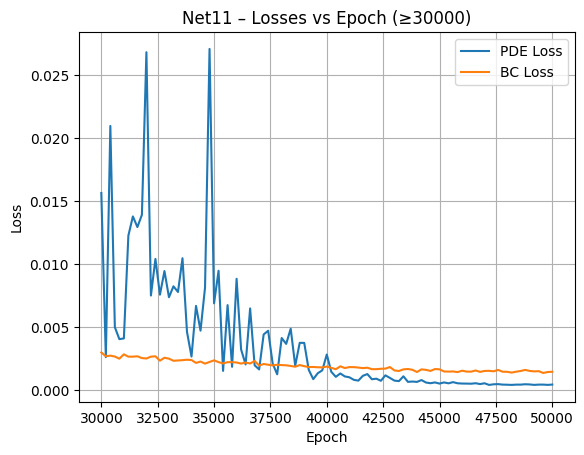

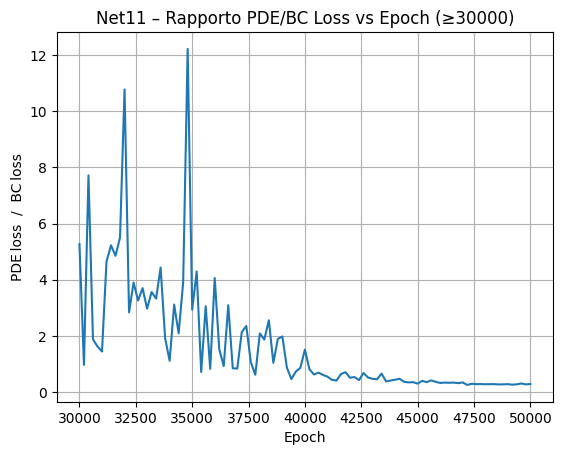

In [21]:
df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 30000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / df_plot["bc_loss"]

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  BC loss")
plt.grid(True)
plt.show()

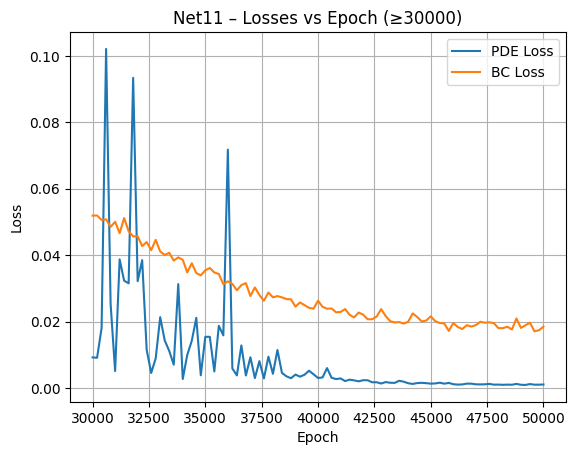

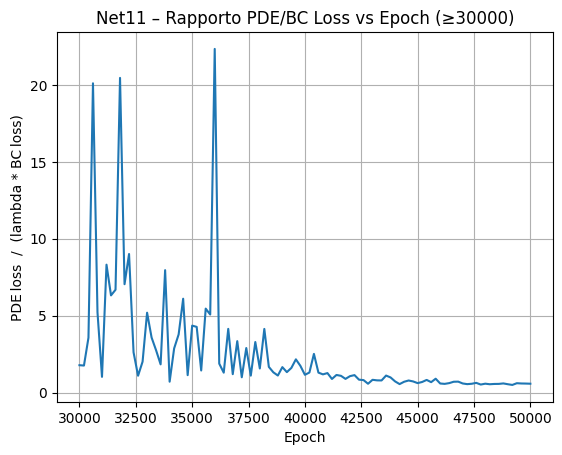

In [22]:
df = pd.read_csv("training_log_lambda0.100.csv")

df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 30000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (df_plot["bc_loss"] * 0.1)

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  (lambda * BC loss)")
plt.grid(True)
plt.show()

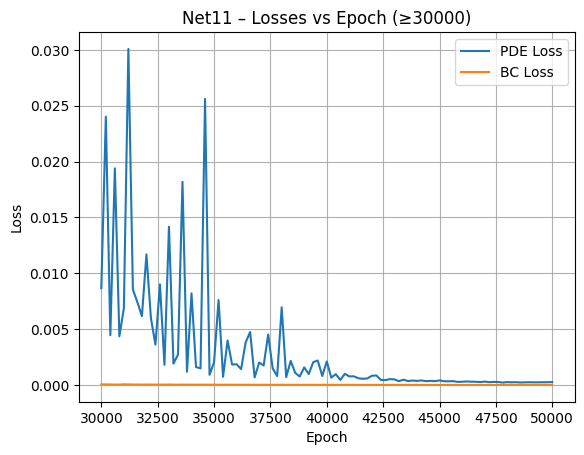

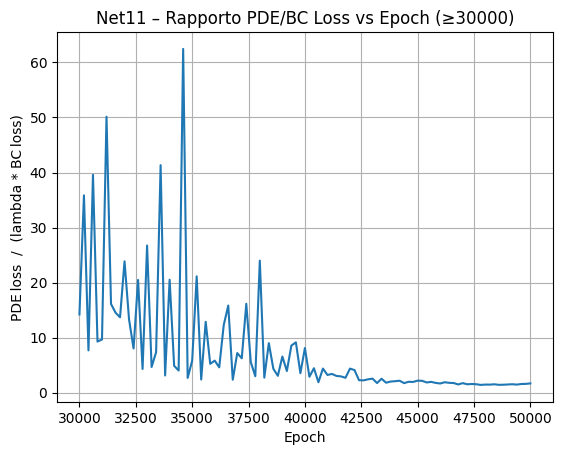

In [24]:
df = pd.read_csv("training_log_lambda10.000.csv")

df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 30000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (df_plot["bc_loss"] * 10)

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  (lambda * BC loss)")
plt.grid(True)
plt.show()

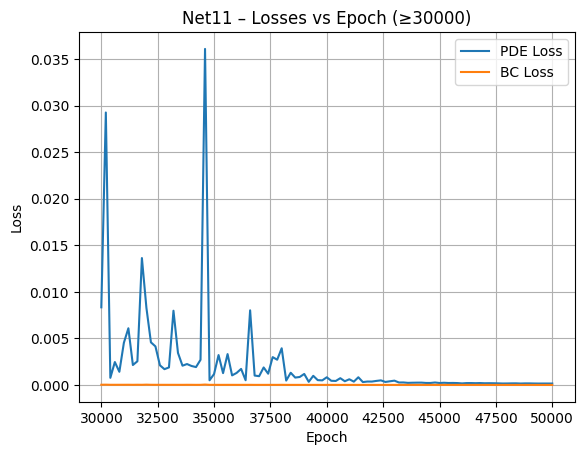

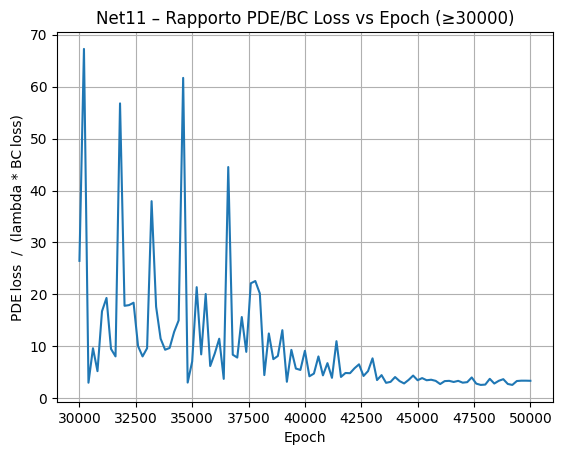

In [25]:
df = pd.read_csv("training_log_lambda15.000.csv")

df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 30000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (df_plot["bc_loss"] * 15)

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  (lambda * BC loss)")
plt.grid(True)
plt.show()

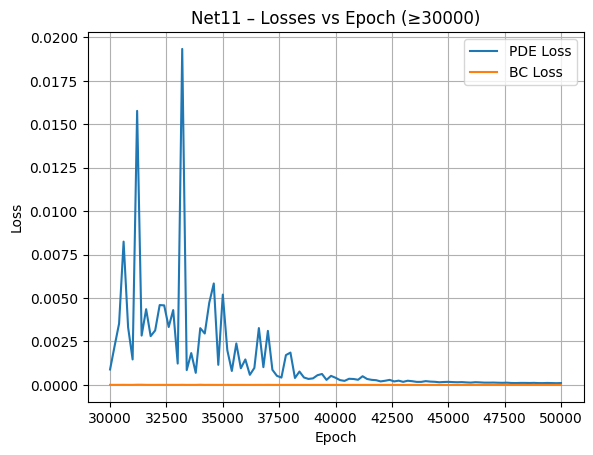

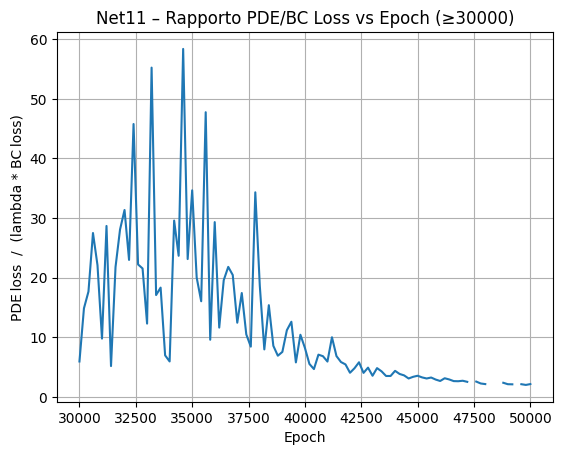

In [26]:
df = pd.read_csv("training_log_lambda50.000.csv")

df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 30000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (df_plot["bc_loss"] * 50)

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  (lambda * BC loss)")
plt.grid(True)
plt.show()

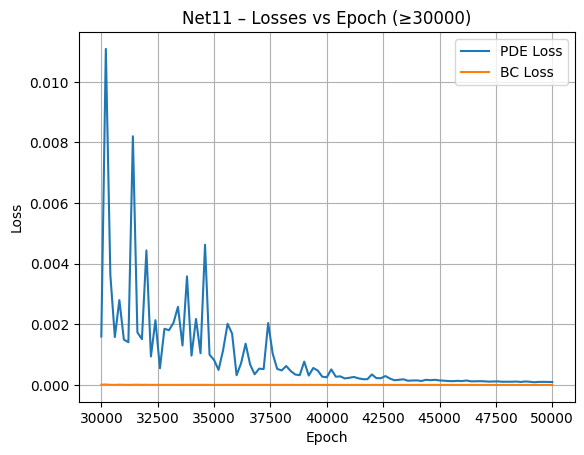

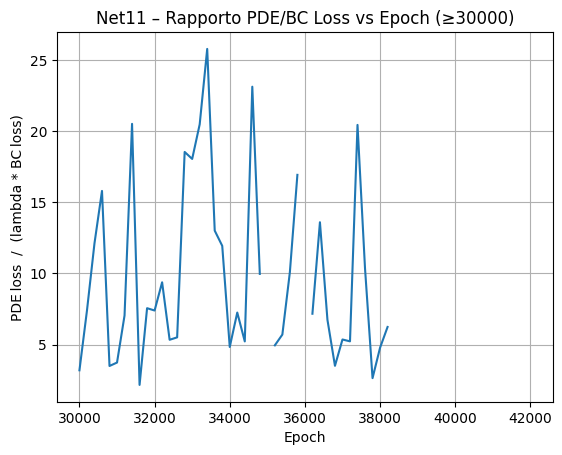

In [43]:
df = pd.read_csv("training_log_lambda100.000.csv")

df_net11 = df[df['net'] == 'Net11()']
df_plot = df_net11[df_net11["epoch"] >= 30000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (df_plot["bc_loss"] * 100)

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/BC Loss vs Epoch (≥30000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  (lambda * BC loss)")
plt.grid(True)
plt.show()

### lambda_weight = 0.75

In [ ]:
df = pd.read_csv("training_log_lambda0.750.csv")
df_net11 = df[df['net'] == 'Net11']
df_plot = df_net11[df_net11["epoch"] >= 15000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (0.75 * df_plot["bc_loss"])

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/0.75 * BC Loss vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  BC loss")
plt.grid(True)
plt.show()

# qua abbastanza come per 1 ma alla fine scende di piu quindi meglio 1

### lambda_weight = 1.25

In [ ]:
df = pd.read_csv("training_log_lambda1.250.csv")
df_net11 = df[df['net'] == 'Net11']
df_plot = df_net11[df_net11["epoch"] >= 15000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (1.25 * df_plot["bc_loss"])

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/1.25 * BC Loss vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  BC loss")
plt.grid(True)
plt.show()

# qua abbastanza come per 1 ma alla fine scende di piu quindi meglio 1

### lambda_weight = 1.5

In [ ]:
df = pd.read_csv("training_log_lambda1.500.csv")
df_net11 = df[df['net'] == 'Net11']
df_plot = df_net11[df_net11["epoch"] >= 15000].copy()

plt.figure()
plt.plot(df_plot["epoch"], df_plot["pde_loss"], label="PDE Loss")
plt.plot(df_plot["epoch"], df_plot["bc_loss"], label="BC Loss")
plt.title("Net11 – Losses vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# calcola il rapporto
df_plot["loss_ratio"] = df_plot["pde_loss"] / (1.5 * df_plot["bc_loss"])

plt.figure()
plt.plot(df_plot["epoch"], df_plot["loss_ratio"])
plt.title("Net11 – Rapporto PDE/1.5 * BC Loss vs Epoch (≥15000)")
plt.xlabel("Epoch")
plt.ylabel("PDE loss  /  BC loss")
plt.grid(True)
plt.show()

#### COMMENTO GENERALE NET11
1. lambda = 0.75
2. lambda = 0.1
4. lambda = 1.25
5. lambda = 1.5
   
Sono più bilanciati con lambda = 1, perché negli altri casi finisce sempre la loss bc per sovrastare la loss pde.

In [30]:
def compute_L2_H1_errors_separated(HF_u_set, HF_ux_set, HF_uy_set,
                                   POD_u_set, POD_ux_set, POD_uy_set,
                                   weights=None):
    """
    Compute average L2 and H1 norm errors over a set of HF and POD values
    passed as separate arrays for u, ux, uy.
    Average bc we have all the solutions varying mu in test set.

    Parameters:
    - HF_u_set: list of np.ndarray, each is HF solution u for a given mu
    - HF_ux_set: list of np.ndarray, HF derivative in x
    - HF_uy_set: list of np.ndarray, HF derivative in y
    - POD_u_set: list of np.ndarray, POD solution u
    - POD_ux_set: list of np.ndarray, POD derivative in x
    - POD_uy_set: list of np.ndarray, POD derivative in y
    - weights: np.ndarray or None, quadrature weights (same length as each u)

    Returns:
    - dict with average L2 and H1 norm errors
    """

    l2_errors = []
    h1_errors = []
    l2_rel_errors = []
    h1_rel_errors = []

    for u_HF, ux_HF, uy_HF, u_POD, ux_POD, uy_POD in zip(
        HF_u_set, HF_ux_set, HF_uy_set,
        POD_u_set, POD_ux_set, POD_uy_set):

        # Compute errors
        err_u = u_POD - u_HF
        err_ux = ux_POD - ux_HF
        err_uy = uy_POD - uy_HF

        if weights is not None:
            l2 = np.sqrt(np.sum(weights * err_u**2))
            h1 = np.sqrt(np.sum(weights * (err_u**2 + err_ux**2 + err_uy**2)))
            l2_rel = l2/np.sqrt(np.sum(weights * u_HF**2))
            h1_rel = h1/np.sqrt(np.sum(weights * (u_HF**2 + ux_HF**2 + uy_HF**2)))
        else:
            l2 = np.linalg.norm(err_u)
            h1 = np.sqrt(np.linalg.norm(err_u)**2 +
                         np.linalg.norm(err_ux)**2 +
                         np.linalg.norm(err_uy)**2)

        l2_errors.append(l2)
        h1_errors.append(h1)
        l2_rel_errors.append(l2_rel)
        h1_rel_errors.append(h1_rel)

    avg_l2 = np.mean(l2_errors)
    avg_h1 = np.mean(h1_errors)
    avg_l2_rel = np.mean(l2_rel_errors)
    avg_h1_rel = np.mean(h1_rel_errors)

    print(f"Avg_L2_Norm_Error computed on quadrature points: {avg_l2:.4e}")
    print(f"Avg_H1_Norm_Error computed on quadrature points: {avg_h1:.4e}")
    print(f"Avg_L2_Norm_Rel_Error computed on quadrature points: {avg_l2_rel:.4e}")
    print(f"Avg_H1_Norm_Rel_Error computed on quadrature points: {avg_h1_rel:.4e}")
    print('-----------------------------------------------------')

    return {
        "Avg_L2_Norm_Error computed on quadrature points": avg_l2,
        "Avg_H1_Norm_Error computed on quadrature points": avg_h1,
        "Avg_L2_Norm_Rel_Error computed on quadrature points": avg_l2_rel,
        "Avg_H1_Norm_Rel_Error computed on quadrature points": avg_h1_rel
    }


In [38]:
import pandas as pd
import numpy as np

# Carica il CSV delle predizioni
df = pd.read_csv("predizioni_u.csv")

# Estrai i valori come array NumPy: shape (N_punti, N_mu)
sol_quad_pinn = df.values.T
print(np.array(sol_quad_hf).shape)

print(f"Caricate predizioni: shape = {sol_quad_pinn.shape}")

# Carica il CSV della derivata rispetto a x
df = pd.read_csv("predizioni_ux.csv")

# Estrai i valori come array NumPy: shape (N_punti, N_mu)
der_x_quad_pinn = df.values.T
print(np.array(sol_quad_hf).shape)

# Carica il CSV della derivata rispetto a y
df = pd.read_csv("predizioni_uy.csv")

# Estrai i valori come array NumPy: shape (N_punti, N_mu)
der_y_quad_pinn = df.values.T
print(np.array(sol_quad_hf).shape)

# Carica il CSV dei tempi
df = pd.read_csv("tempi_pinn.csv")

# Estrai i valori come array NumPy: shape (N_punti, N_mu)
times_pinn = df.values.T
times_pinn = times_pinn[1]
print(np.array(sol_quad_hf).shape)


(100, 4623)
Caricate predizioni: shape = (100, 4623)
(100, 4623)
(100, 4623)
(100, 4623)
[0.00111771 0.00093842 0.00119877 0.00122094 0.00120854 0.00126886
 0.00118208 0.00124431 0.00124264 0.00121546 0.0012269  0.00152731
 0.00127769 0.00125933 0.00125074 0.00123715 0.00144219 0.00127411
 0.00093079 0.000916   0.00092697 0.00137901 0.00117683 0.00112343
 0.00111198 0.00104046 0.00100064 0.0009129  0.00087214 0.00099778
 0.00130272 0.0016489  0.00128627 0.00127649 0.00119686 0.0012536
 0.00119352 0.00103855 0.00127959 0.00134873 0.00124002 0.00162363
 0.00137138 0.00127411 0.00129414 0.00129843 0.00141311 0.00136209
 0.00140834 0.00141597 0.00161934 0.00128603 0.00131607 0.00126266
 0.00125647 0.00127912 0.00126767 0.0012877  0.00123501 0.00121212
 0.00124145 0.00121832 0.0012176  0.00121856 0.00118065 0.00123501
 0.0019207  0.00123692 0.00121784 0.00120783 0.00119305 0.0012455
 0.00121546 0.00119472 0.00127316 0.00148368 0.00147867 0.00149322
 0.00149441 0.00149918 0.00248265 0.000928

In [39]:
#errors_u_set = compute_L2_error(sol_quad_hf, sol_quad_PINN, weights=quadratureWeights)
errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Avg_L2_Norm_Error computed on quadrature points: 2.1814e-02
Avg_H1_Norm_Error computed on quadrature points: 6.4829e-01
Avg_L2_Norm_Rel_Error computed on quadrature points: 4.2226e-02
Avg_H1_Norm_Rel_Error computed on quadrature points: 1.4055e-01
-----------------------------------------------------


In [41]:
# calcolo dello speed up

speed_ups = np.array(times_hf)/np.array(times_pinn)
speed_up = np.mean(speed_ups)
print("Avg speed-up: ", speed_up)

Avg speed-up:  12.995705745739228
